In [ ]:
# unzipping the dataset
!unzip data.zip -d ./

# Prepare Dataset

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array

def load_and_preprocess_image(file_path):
    img = load_img(file_path, target_size=(256, 256))
    img = img_to_array(img) / 255.0  # Normalize pixel values to [0, 1]
    return img

def load_dataset(data_dir):
    X_paths = tf.io.gfile.glob(data_dir + '/X/*.jpg')
    y_paths = tf.io.gfile.glob(data_dir + '/y/*.jpg')

    X_images = [load_and_preprocess_image(path) for path in X_paths]
    y_images = [load_and_preprocess_image(path) for path in y_paths]

    return tf.convert_to_tensor(X_images), tf.convert_to_tensor(y_images)

# Load train and test datasets
train_X, train_y = load_dataset('data/train')
test_X, test_y = load_dataset('data/test')

# Define The Model

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.regularizers import l2

def combined_loss(y_true, y_pred):
  ssim_loss = 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, 1.0))
  return ssim_loss


model = Sequential([
    # Encoder
    Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(256, 256, 3)),
    MaxPooling2D((2, 2), padding='same'),

    Conv2D(128, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2), padding='same'),

    Conv2D(256, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2), padding='same'),

    # Decoder
    Conv2D(256, (3, 3), activation='relu', padding='same'),
    UpSampling2D((2, 2)),

    Conv2D(128, (3, 3), activation='relu', padding='same'),
    UpSampling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu', padding='same'),
    UpSampling2D((2, 2)),

    Conv2D(3, (3, 3), activation='sigmoid', padding='same')  # Output layer with 3 channels (RGB)
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss=combined_loss, metrics=['accuracy'])
model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 256, 256, 64)      1792      
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 128, 128, 64)      0         
 g2D)                                                            
                                                                 
 conv2d_19 (Conv2D)          (None, 128, 128, 128)     73856     
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 64, 64, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_20 (Conv2D)          (None, 64, 64, 256)       295168    
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 32, 32, 256)      

# Train the model

## Re-train Model

In [ ]:
import tensorflow as tf
from keras.utils import custom_object_scope

# Define the combined_loss function here (if you have it)
def combined_loss(y_true, y_pred):
  ssim_loss = 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, 1.0))
  return ssim_loss

# Load the model within a custom object scope
with custom_object_scope({'combined_loss': combined_loss}):
    model = tf.keras.models.load_model('correction-finalv7.h5')
history = model.fit(train_X, train_y, epochs=20, batch_size=32, validation_data=(test_X, test_y))

Epoch 1/20
10/10 [==============================] - 6s 413ms/step - loss: 0.1880 - accuracy: 0.8424 - val_loss: 0.1863 - val_accuracy: 0.8677
Epoch 2/20
10/10 [==============================] - 4s 409ms/step - loss: 0.1875 - accuracy: 0.8239 - val_loss: 0.1870 - val_accuracy: 0.8048
Epoch 3/20
10/10 [==============================] - 4s 409ms/step - loss: 0.1863 - accuracy: 0.8307 - val_loss: 0.1860 - val_accuracy: 0.8105
Epoch 4/20
10/10 [==============================] - 4s 382ms/step - loss: 0.1861 - accuracy: 0.8400 - val_loss: 0.1852 - val_accuracy: 0.8324
Epoch 5/20
10/10 [==============================] - 4s 379ms/step - loss: 0.1858 - accuracy: 0.8149 - val_loss: 0.1859 - val_accuracy: 0.8556
Epoch 6/20
10/10 [==============================] - 4s 383ms/step - loss: 0.1858 - accuracy: 0.8207 - val_loss: 0.1859 - val_accuracy: 0.8693
Epoch 7/20
10/10 [==============================] - 4s 382ms/step - loss: 0.1861 - accuracy: 0.8166 - val_loss: 0.1858 - val_accuracy: 0.8390
Epoch 

## Train new model

In [ ]:
history = model.fit(train_X, train_y, epochs=20, batch_size=32, validation_data=(test_X, test_y))

# Evaulate the Model

3/3 [==============================] - 0s 107ms/step - loss: 0.1853 - accuracy: 0.8216
Test loss: [0.1853451281785965, 0.8215578198432922]


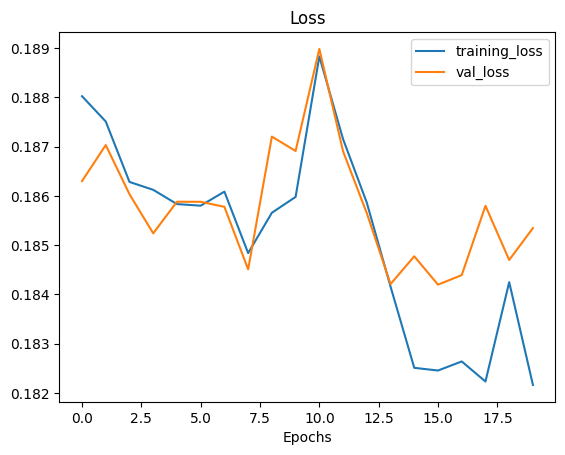

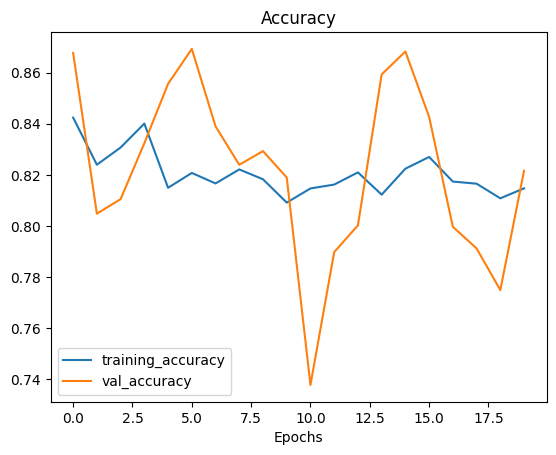

In [ ]:
from matplotlib import pyplot as plt

def plot_loss_curves(history):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]

    accuracy = history.history["accuracy"]
    val_accuracy = history.history["val_accuracy"]

    epochs = range(len(history.history["loss"]))

    # Plot loss
    plt.plot(epochs, loss, label="training_loss")
    plt.plot(epochs, val_loss, label="val_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()

    # Plot accuracy
    plt.figure()
    plt.plot(epochs, accuracy, label="training_accuracy")
    plt.plot(epochs, val_accuracy, label="val_accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()

loss = model.evaluate(test_X, test_y)
print(f'Test loss: {loss}')
plot_loss_curves(history)

# Save model

In [ ]:
model.save('correction-finalv7.2.h5')

# Inference

In [ ]:
import tensorflow as tf
from keras.utils import custom_object_scope

def combined_loss(y_true, y_pred):
  ssim_loss = 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, 1.0))
  return ssim_loss

# Load the model within a custom object scope
with custom_object_scope({'combined_loss': combined_loss}):
    model = tf.keras.models.load_model('correction-finalv7.2.h5')

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

def preprocess_image(file_path):
    img = load_img(file_path, target_size=(256, 256))
    img = img_to_array(img) / 255.0
    img = np.expand_dims(img, axis=0)
    return img

def deprocess_image(img):
    img = np.clip(img, 0, 1)
    return img[0]


input_image_path = '326.jpg'

input_image = preprocess_image(input_image_path)

predicted_image = model.predict(input_image)
predicted_image = deprocess_image(predicted_image)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('Input (Pixelated)')
plt.imshow(load_img(input_image_path))

plt.subplot(1, 2, 2)
plt.title('Output (Corrected)')
plt.imshow(predicted_image)
plt.show()

1/1 [==============================] - 0s 29ms/step


1/1 [==============================] - 0s 65ms/step
